In [1]:
import anndata
import phate
import scprep
import sklearn
import scanpy as sc
import magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphtools
import seaborn as sns

import SPARC
import tasklogger
import warnings

from scipy.spatial.distance import pdist, squareform, jensenshannon
warnings.simplefilter('ignore')

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Adult_Mouse_Brain')
adata

In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


<AxesSubplot:xlabel='n_genes_by_counts'>

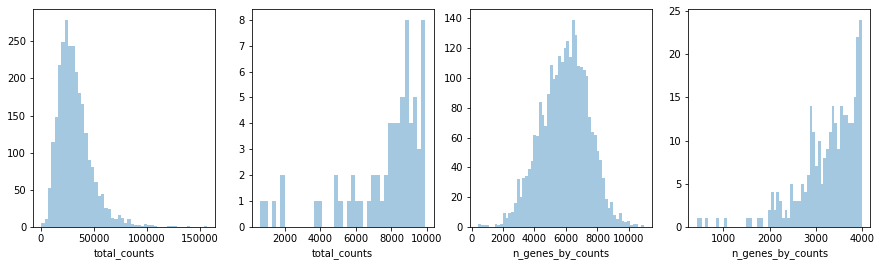

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])


In [6]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=75000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2638


In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

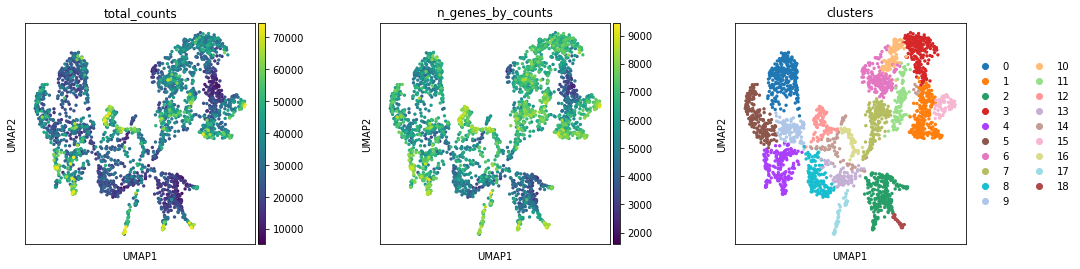

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

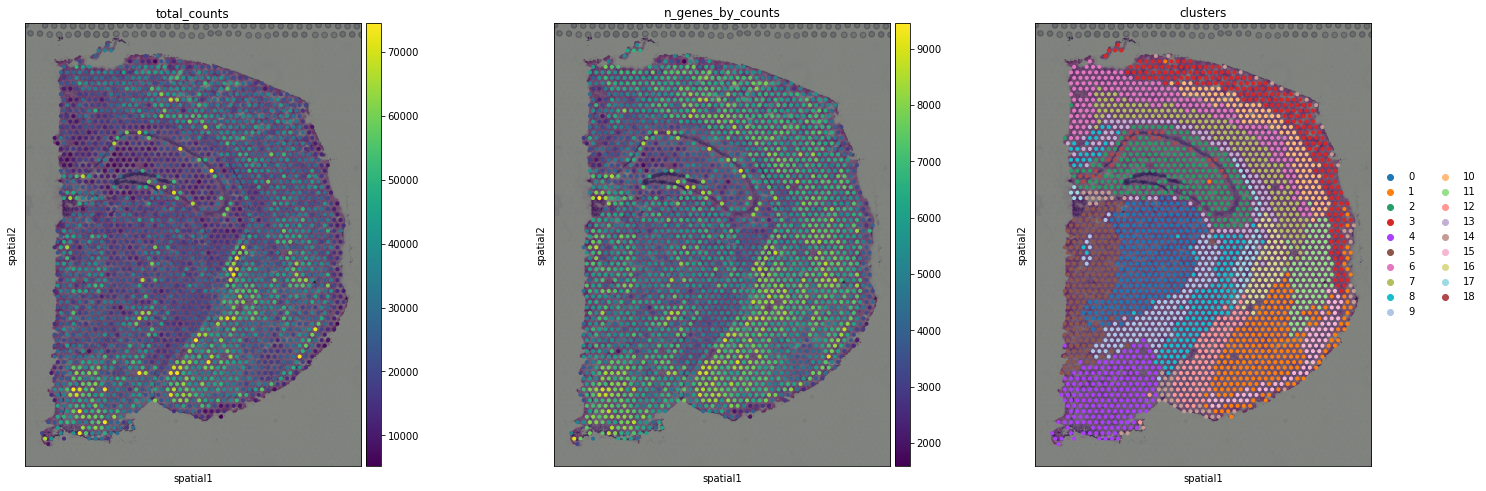

In [10]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts", "clusters"])

### Testing spARC

In [13]:
sparc_op = SPARC.spARC()

In [14]:
data_sparc = sparc_op.fit_transform(expression_X = adata.to_df(),
                                    spatial_X = adata.obs[['array_row', 'array_col']])

Calculating spARC...
  Calculating PCA...
  Calculated PCA in 2.68 seconds.
  Calculating expression graph...
  Calculated expression graph in 0.38 seconds.
  Calculating spatial graph...
  Calculated spatial graph in 0.71 seconds.
HERE LOCAL
  Calculating random walks on expression graph...
  Calculated random walks on expression graph in 0.49 seconds.
  Calculating random walks on spatial graph...
(2638, 2638)
  Calculating spARCed expression data...
  Calculated spARCed expression data in 1.92 seconds.
Calculated spARC in 6.18 seconds.


In [15]:
adata.layers['rna_raw'] = adata.to_df()
adata.layers['rna_sparc'] = data_sparc

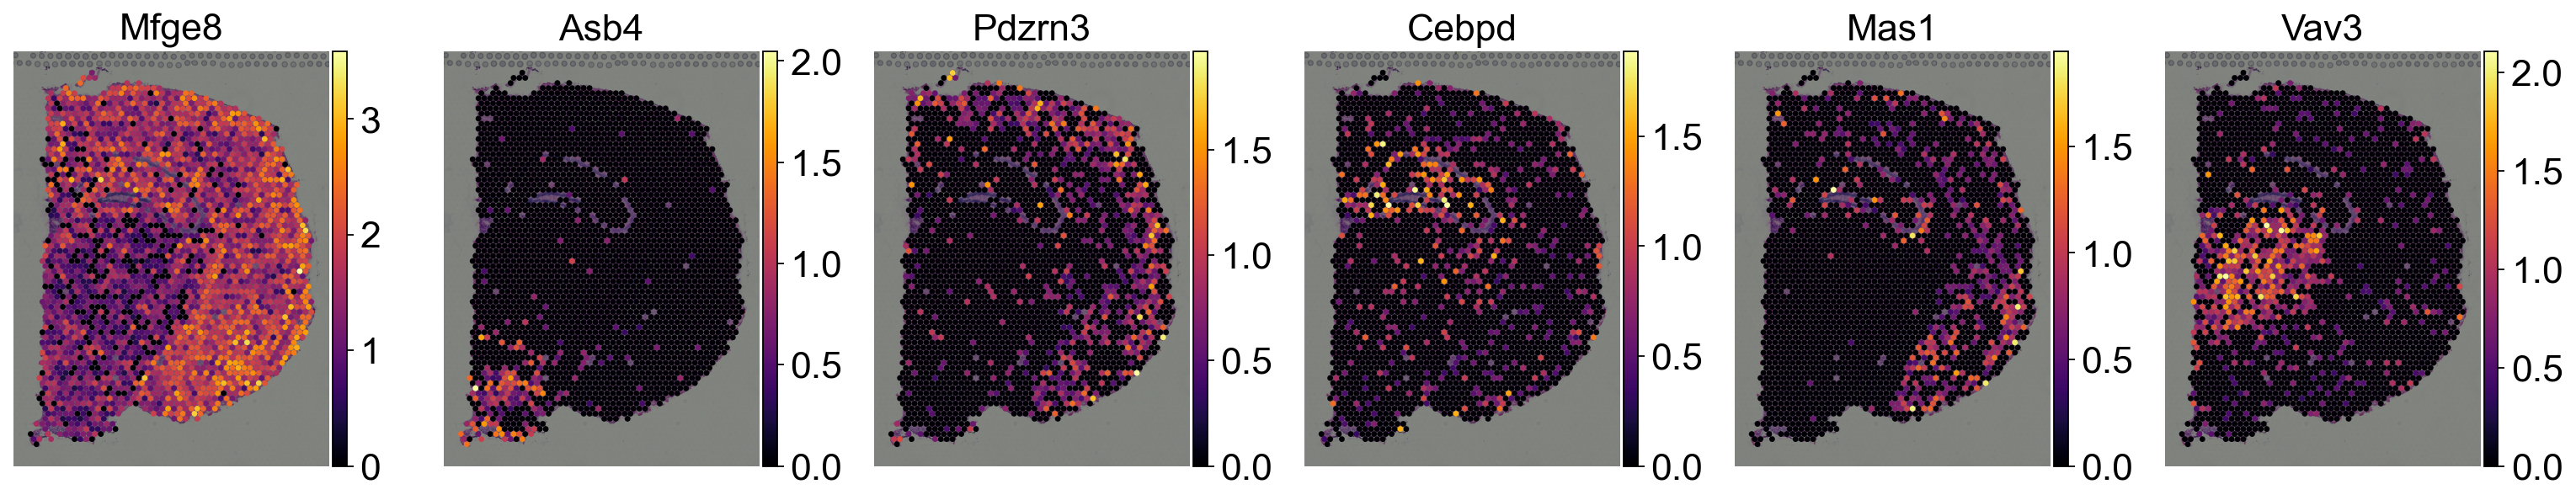

In [16]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_raw', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

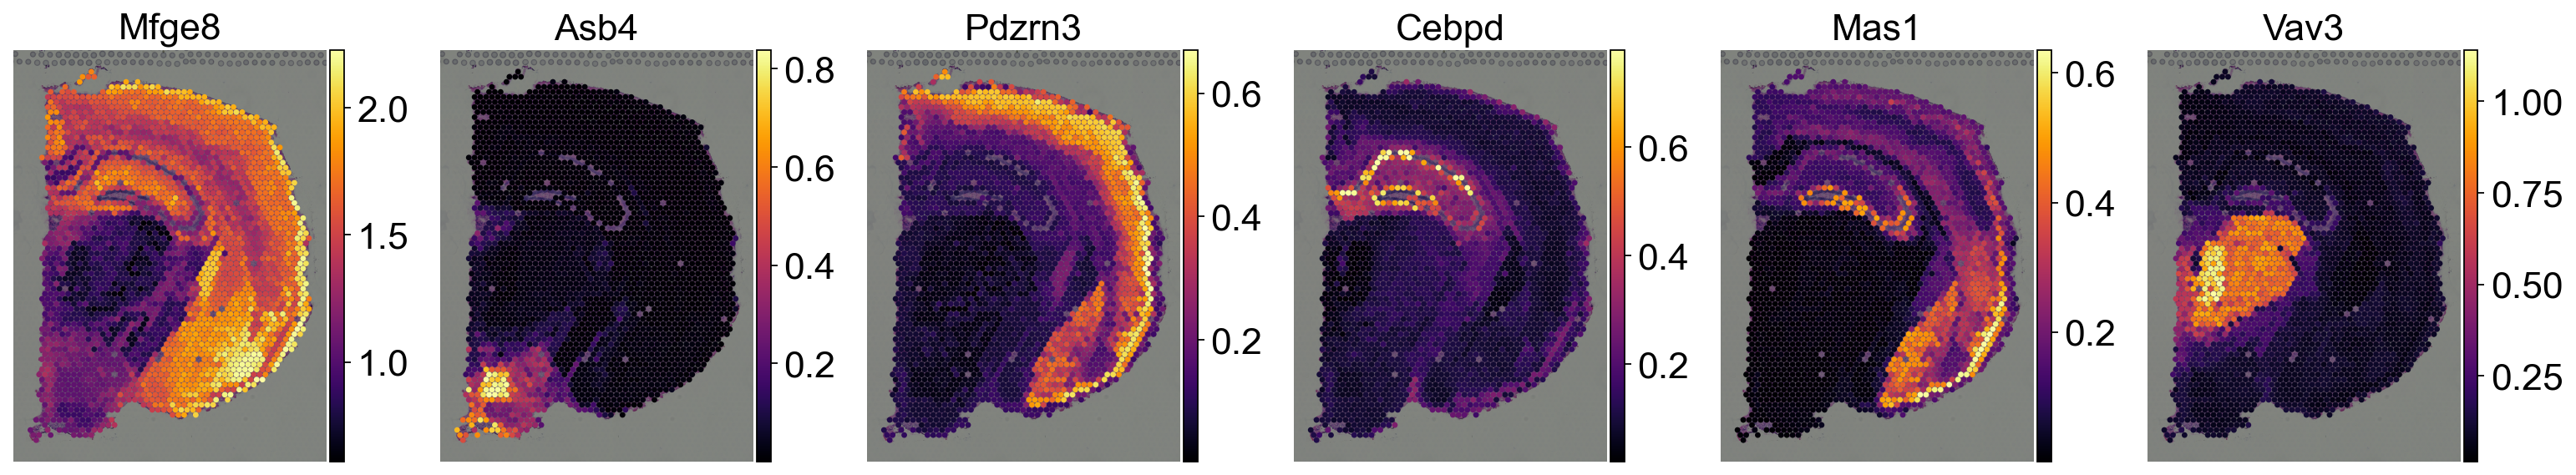

In [17]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

## Testing spARC with different parameters

#### Here, we construct spARC graphs with different numbers of nearest neighbors, modifying the degree to which neighborhoods affect imputation. By default, the number of neighbors for both the expression (RNA) and spatial graphs are 15.

In [28]:
spatial_data = np.array(adata.obs[['array_row', 'array_col']])
G_rna = graphtools.Graph(adata.obsm['X_pca'], knn=5)
G_spatial = graphtools.Graph(spatial_data, knn=3)

new_sparc_op = SPARC.spARC(expression_graph=G_rna, spatial_graph=G_spatial)

In [ ]:
data_sparc = new_sparc_op.fit_transform(expression_X = adata.to_df(),
                                    spatial_X = adata.obs[['array_row', 'array_col']])

In [23]:
adata.layers['rna_raw'] = adata.to_df()
adata.layers['rna_sparc'] = data_sparc

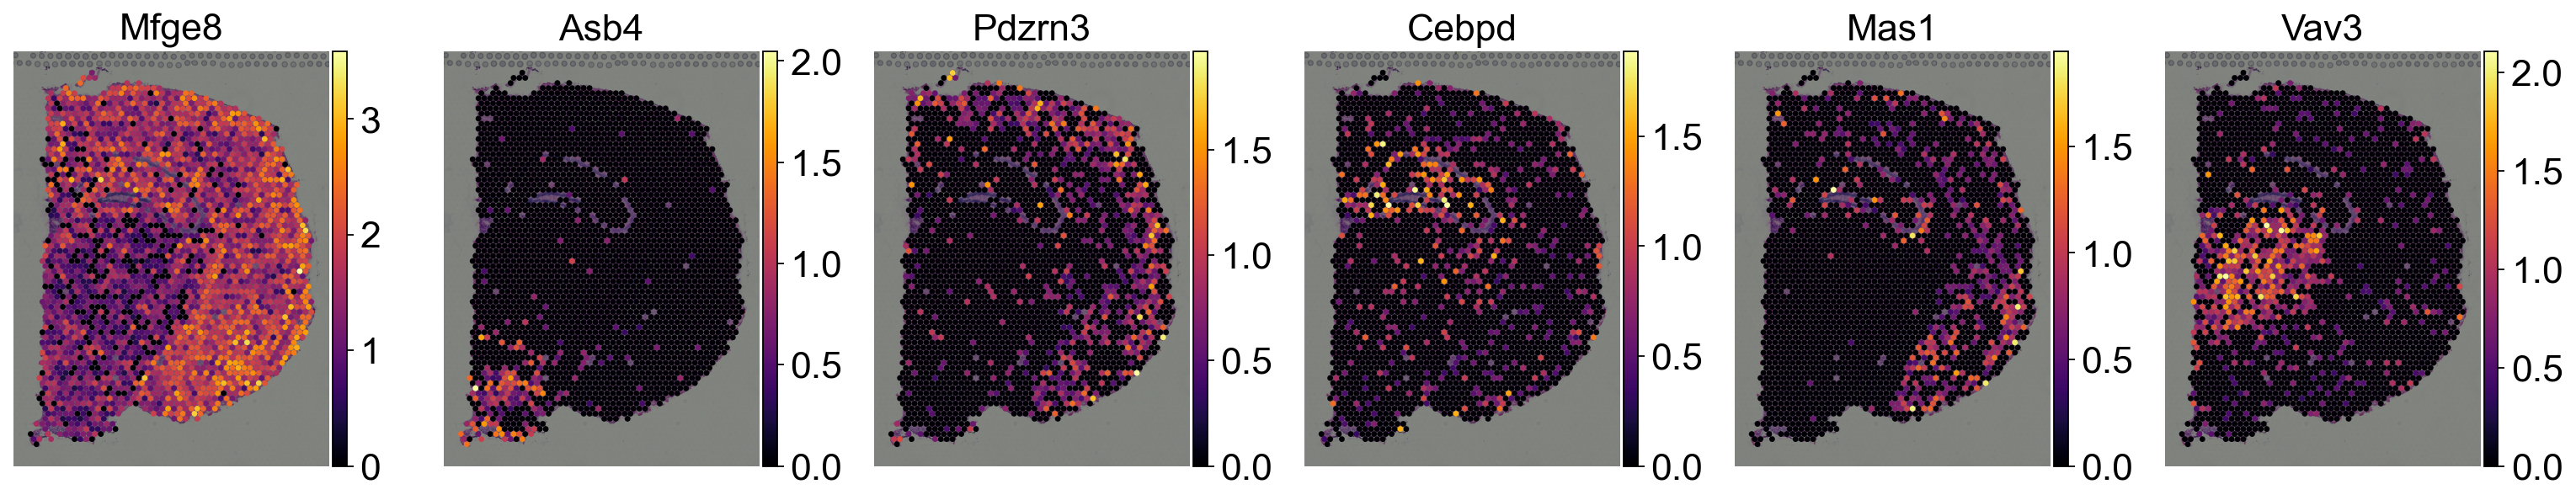

In [24]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_raw', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

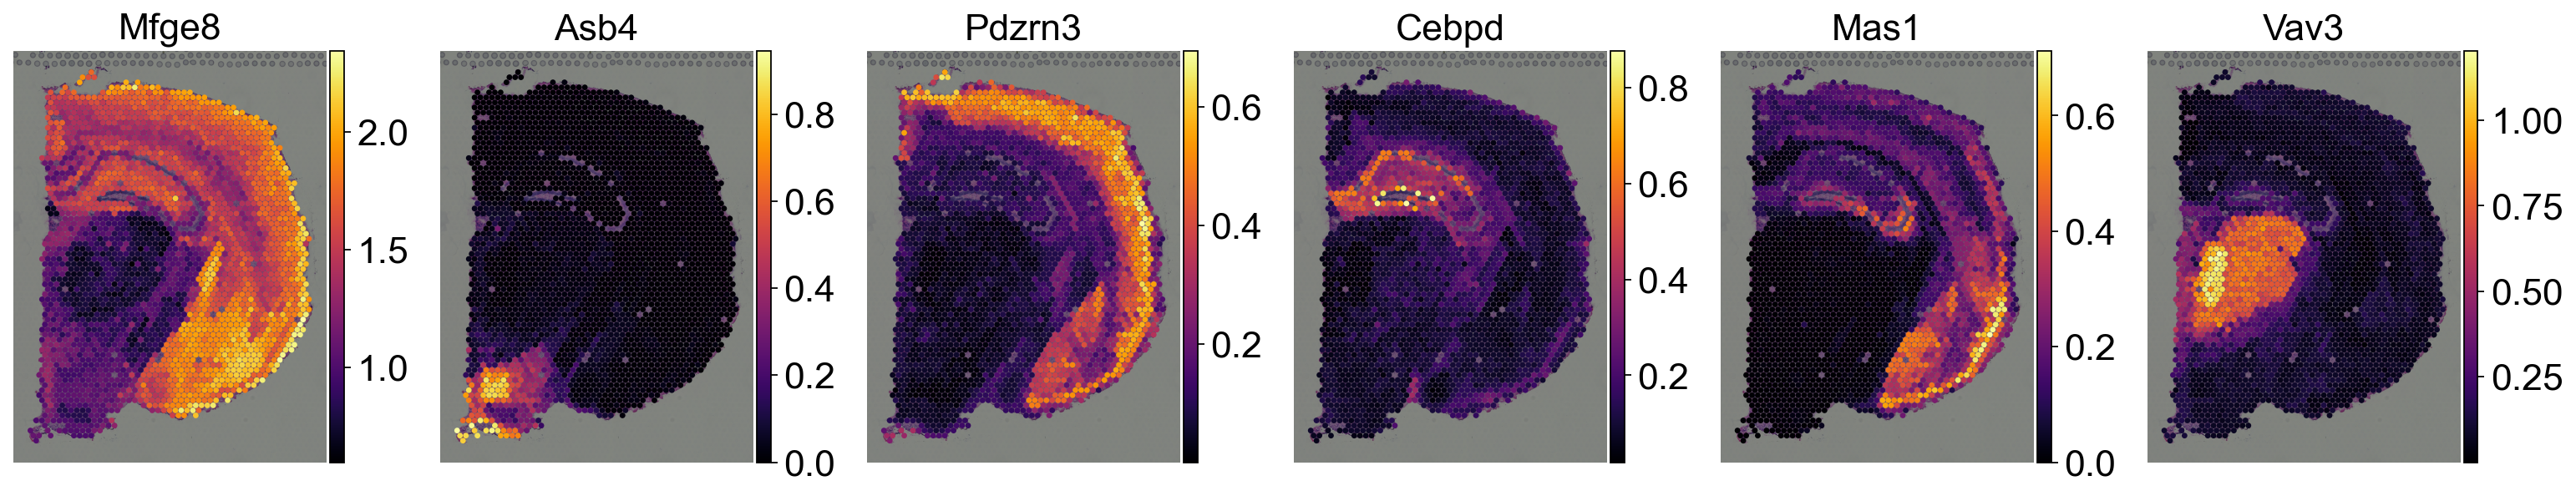

In [25]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

### Check soluble factors

In [26]:
G_spatial = graphtools.Graph(spatial_data, knn=5)
soluable_sparc = sparc_op.diffuse_soluable_factors(soluable_spatial_graph=G_spatial)

Calculating diffusion on soluable factors...
Calculated diffusion on soluable factors in 10.65 seconds.


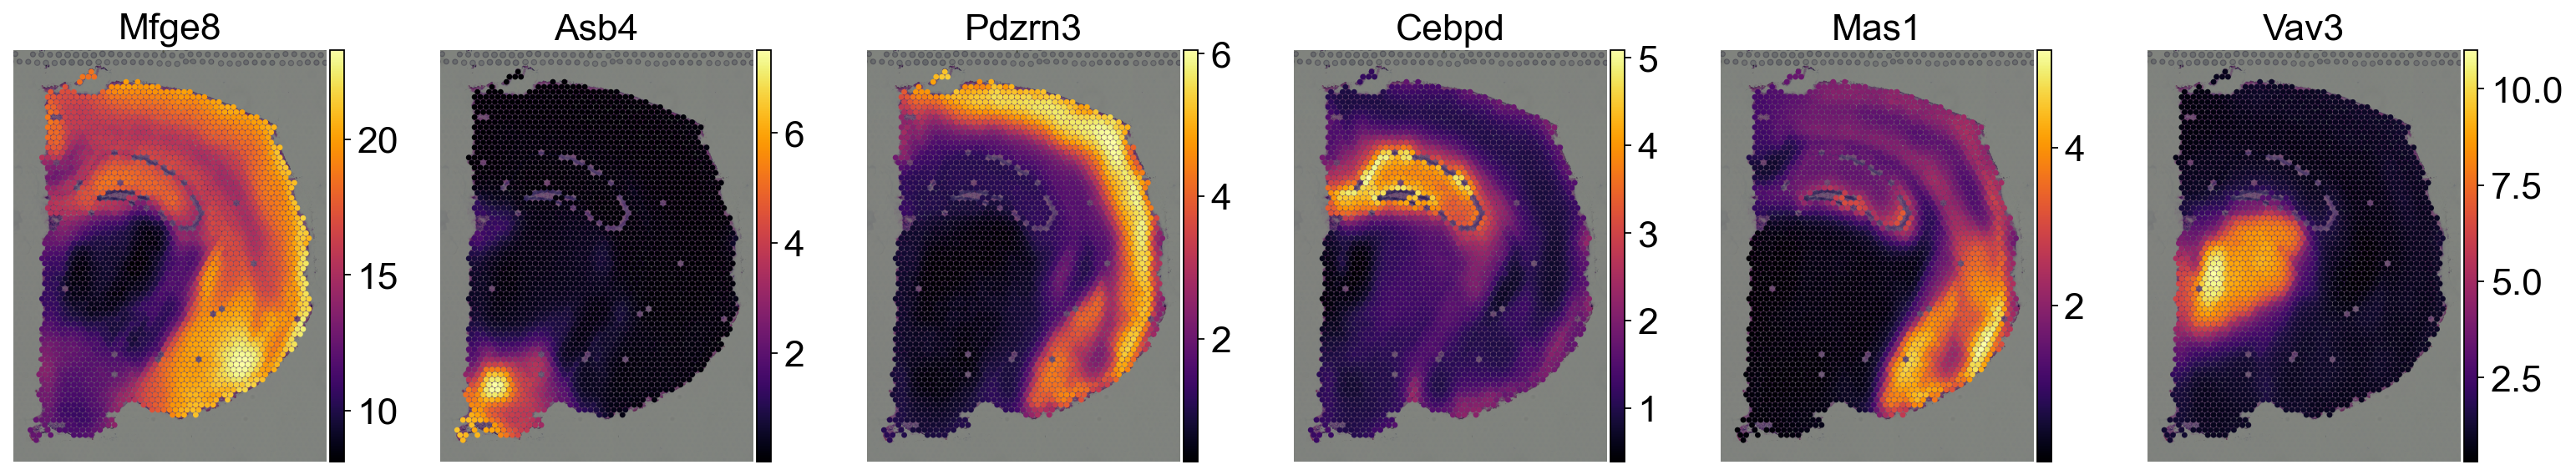

In [27]:
adata.layers['soluable_sparc'] = soluable_sparc
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='soluable_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)